# Convert TVC forcing files to CLASSIC
https://cccma.gitlab.io/classic/makeInputFiles.html

In [1]:
# Env: sc2_v0

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
import os

## Trail Valley Creak, northwestern Canada

The site is a low-center polygon, with herb tundra and no erect vegetation

| Short name | umt |
|:-----------|:----|
| Location | 68.74617°N, 133.50171°W |
| Elevation | 85 m |
| Snow-free albedo | - |
| Simulation period | 2013 to 2019 |
| Temperature/humidity measurement height | 2 m |
| Wind measurement height | 4 m |
| Reference | Dutch et al. ([2022](https://tc.copernicus.org/articles/16/4201/2022/)) |

Southern Arctic tundra site, erect-shrub tundra, tundra dominated by low shrubs <40 cm, continuous permafrost
Elevation: 85 m

Vegetation:
- dominant plant species: Graminoids (Carex spp.), deciduous (Vaccinum uliginosum, Betula glandulosa, Salix glauca) and evergreen
shrubs (Rhododendron groenlandicum)
- rooting depth: maximum set to 40 cm
- average plant height < 40 cm
- average LAI: 0.66 ± 0.11 m2/m2
- plant cover: 92.5 % vascular plants, 31.5 % moss, 51 % lichen
- Bowen ratio:

Climate:
- mean annual precipitation: 240.6 mm (Fluxnet)
- mean annual temperature: -8.2 degrees C (Fluxnet)

Soils:
- silty clay to silt loam
- soil organic matter content:
- continuous permafrost with average thaw depth of 0.74 ± 0.05 m

Soil composition (sand/clay/silt): 18 ± 3 cm organic layer depth  
	mineral soil   35 % sand / 40 % clay (Marsh et al., [2010](https://onlinelibrary.wiley.com/doi/10.1002/hyp.7786))  
                 21 % sand / 16 % clay (Julia Boike, [AWI](https://doi.pangaea.de/10.1594/PANGAEA.962726))

Soil permeable depth: set to 9 m 

PI: Oliver Sonnentag

In [2]:
site = 'tvc'
site_longname = 'Trail Valley Creek, northwestern Canada'

year_start = '2013'
year_end = '2019'

lat = 68.74617
lon = -133.50171

path = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/TVC/TVCSnowCLM/TVCMetData'
path_tmp = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/tmp'
path_out = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/'+site
path_out_CLASSIC = '/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/'+site+'/forcing'

if os.path.exists(path_out):
    print(path_out+' already exist.')
else:
    os.makedirs(path_out)
    print(path_out+' has been created!')

if os.path.exists(path_out_CLASSIC):
    print(path_out_CLASSIC+' already exist.')
else:
    os.makedirs(path_out_CLASSIC)
    print(path_out_CLASSIC+' has been created!')

/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/tvc already exist.
/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/tvc/forcing already exist.


### Open original forcing file

In [69]:
ds = xr.open_dataset(path+'/met_insitu_'+site+'_'+year_start+'_'+year_end+'.nc')
ds

<xarray.Dataset> Size: 4MB
Dimensions:    (time: 61320)
Coordinates:
  * time       (time) datetime64[ns] 491kB 2013-01-01 ... 2019-12-31T23:00:00
Data variables:
    LWdown     (time) float64 491kB ...
    TotPrecip  (time) float64 491kB ...
    Tair       (time) float64 491kB ...
    RH         (time) float64 491kB ...
    Wind       (time) float64 491kB ...
    Psurf      (time) float64 491kB ...
    SWdown     (time) float64 491kB ...
    Qair       (time) float64 491kB ...
Attributes:
    Location:     Field site located at Latitude:68.75 Longitude:226.50
    History:      File created by V. R. Dutch in Dec 2020 using TVC Station d...
    Institution:  Northumbria University, UK

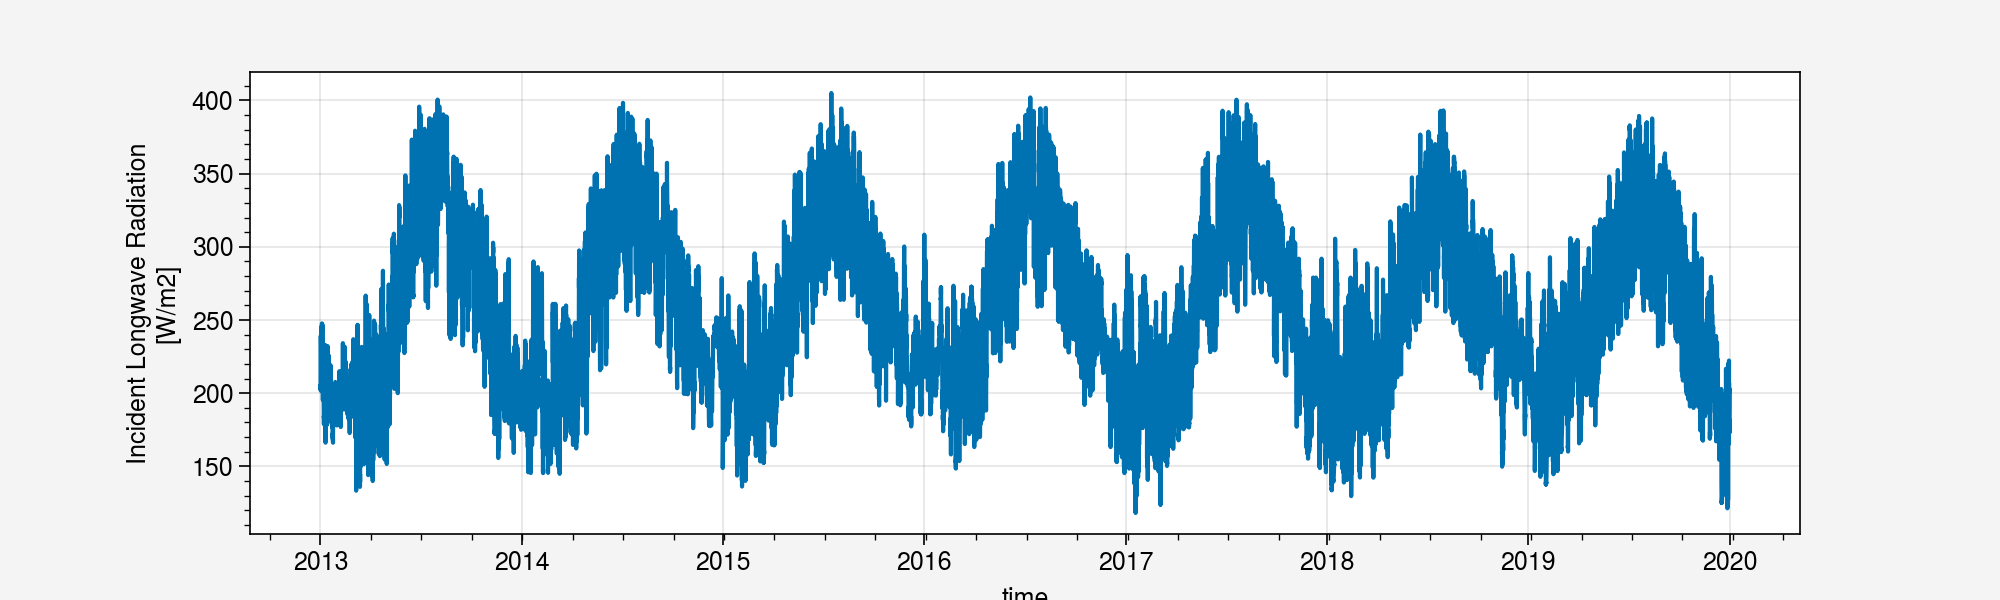

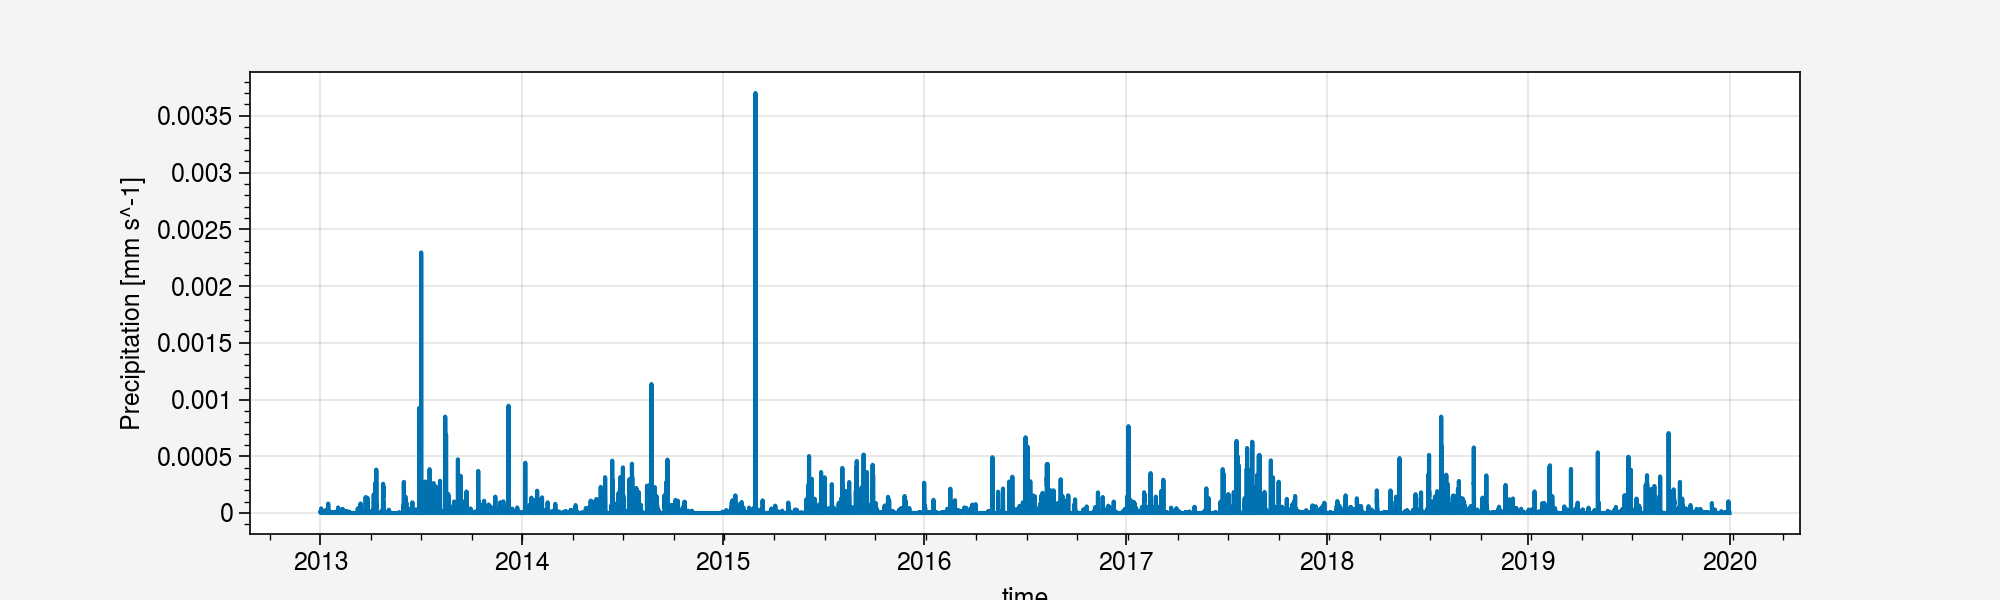

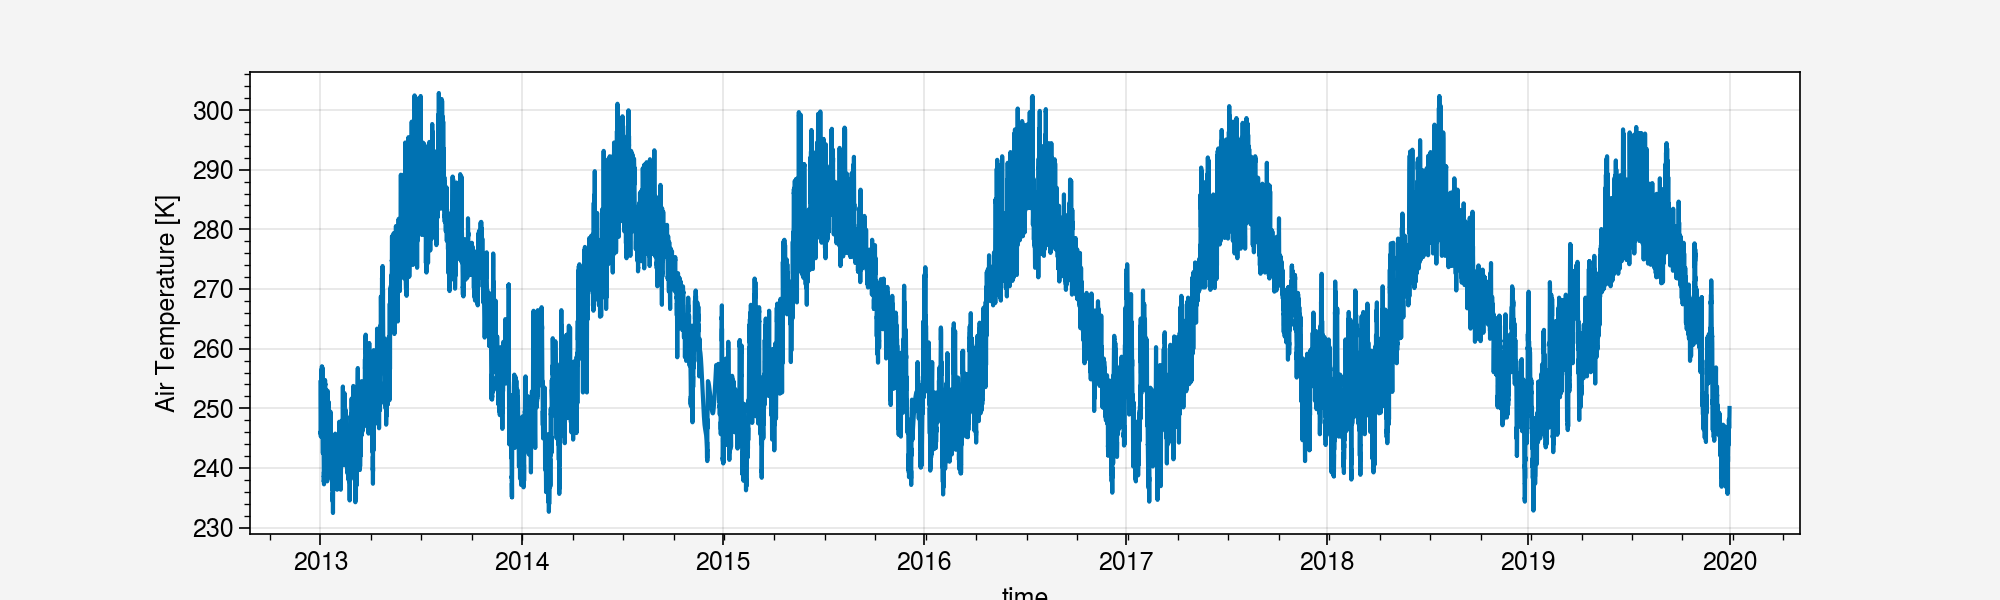

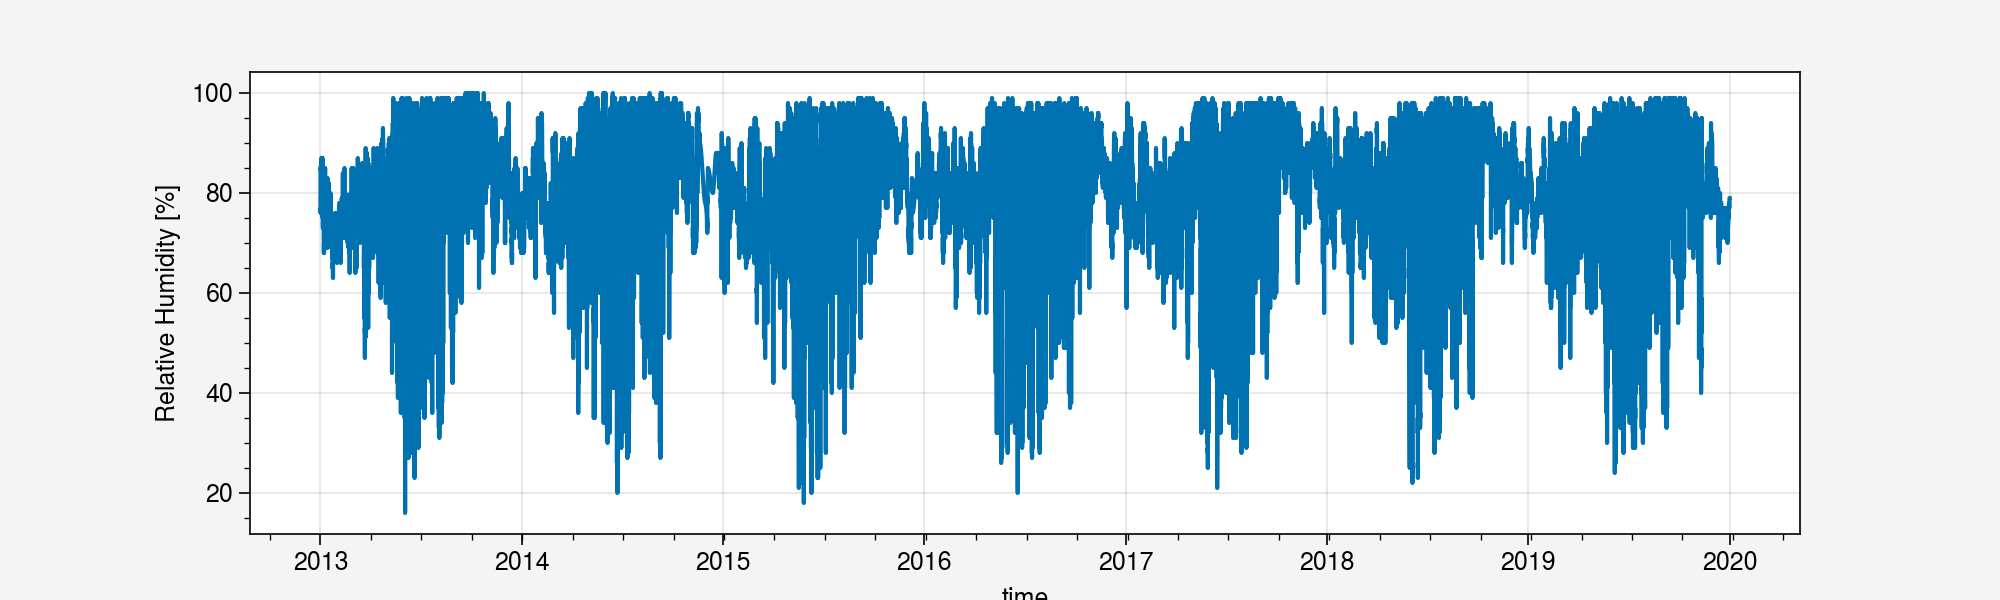

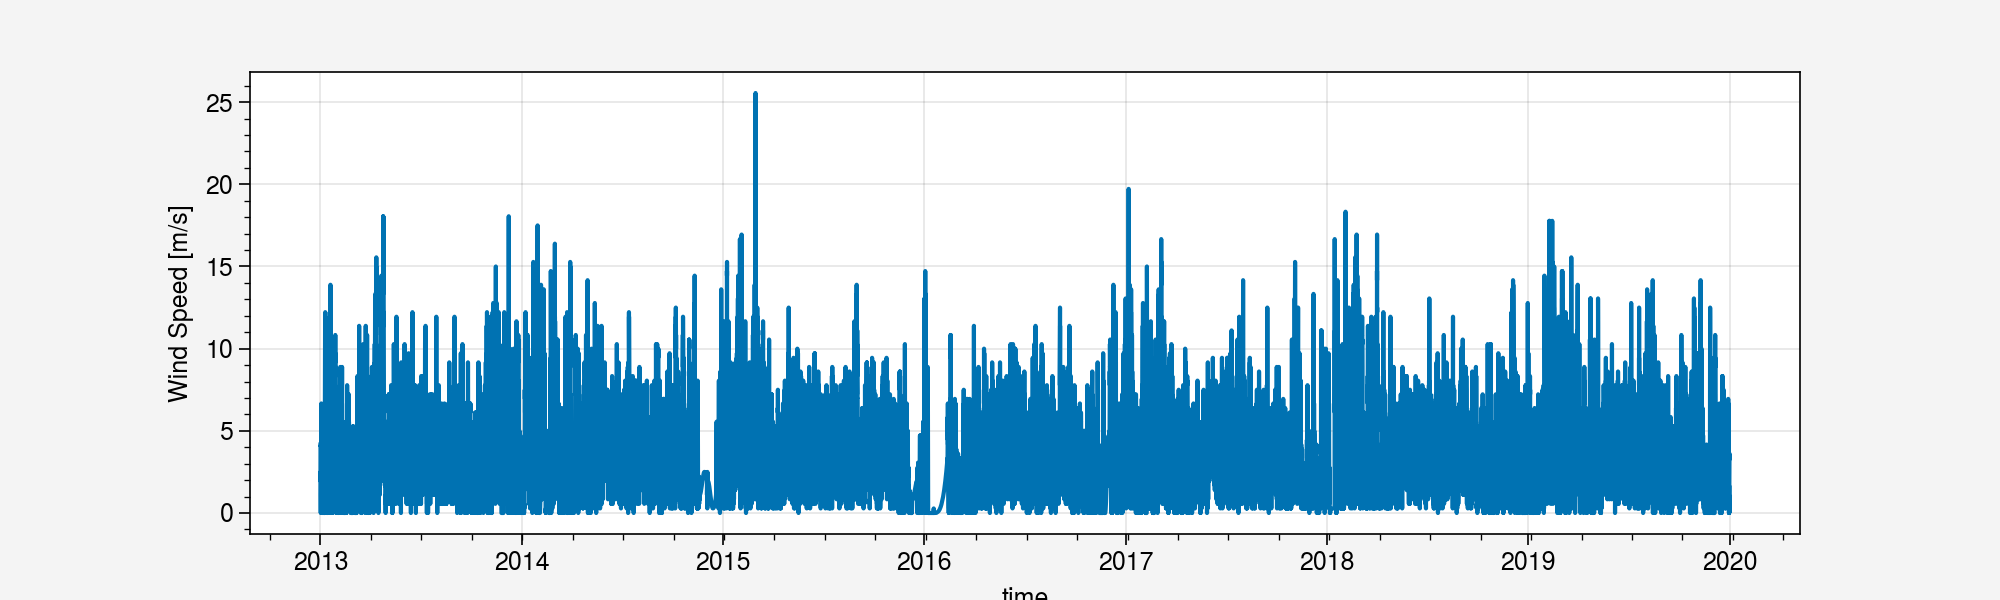

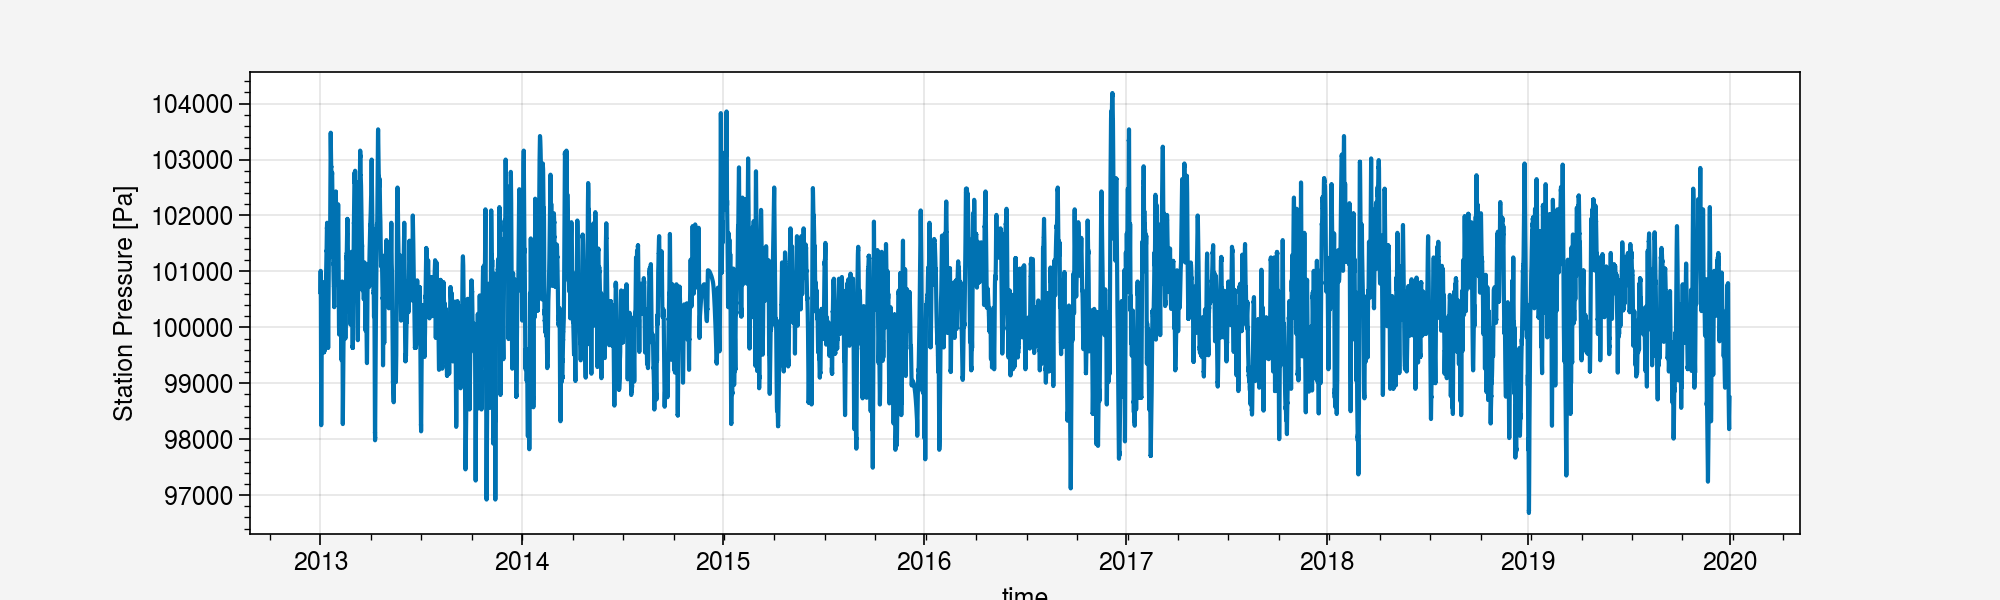

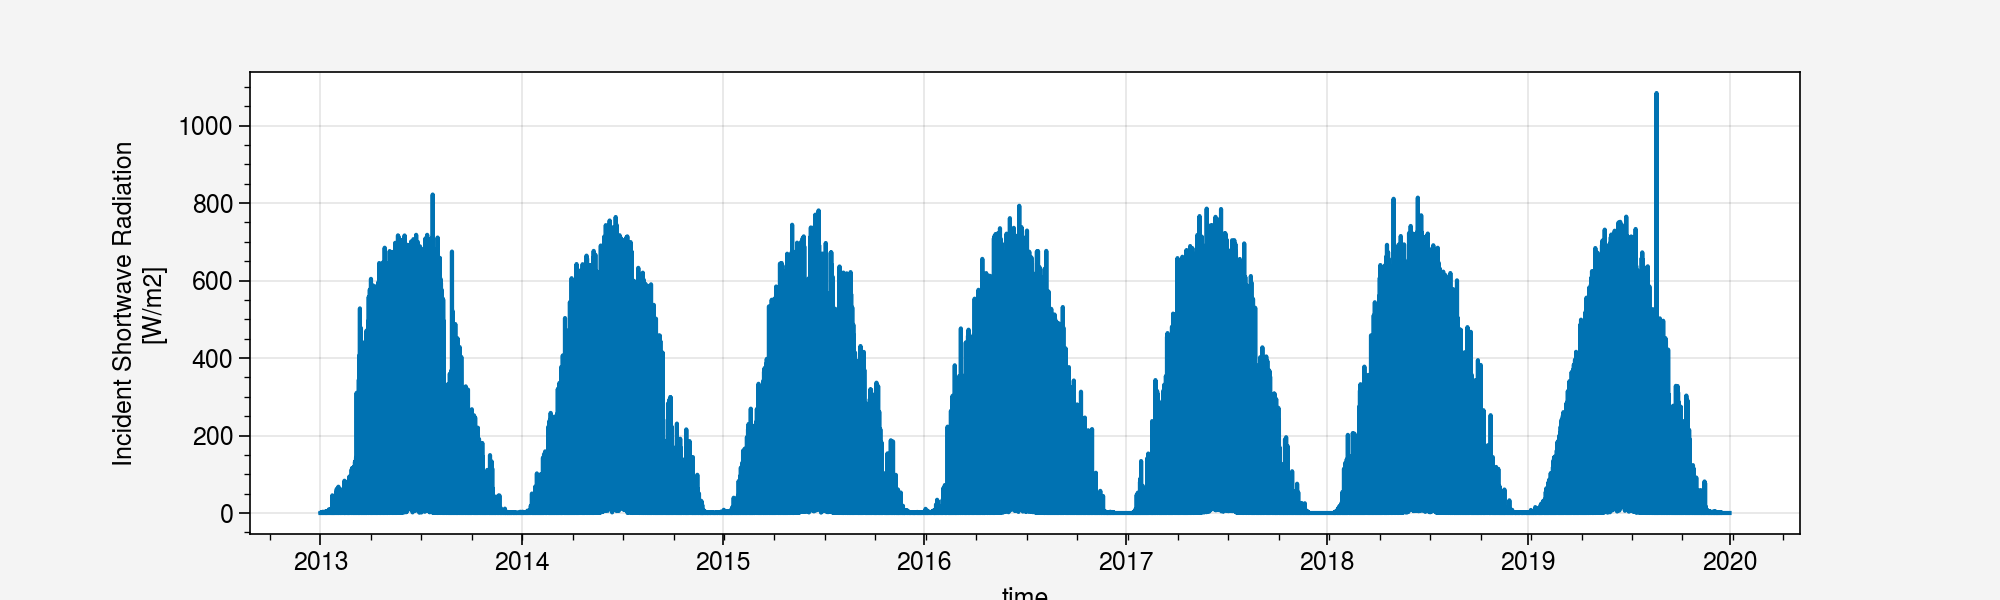

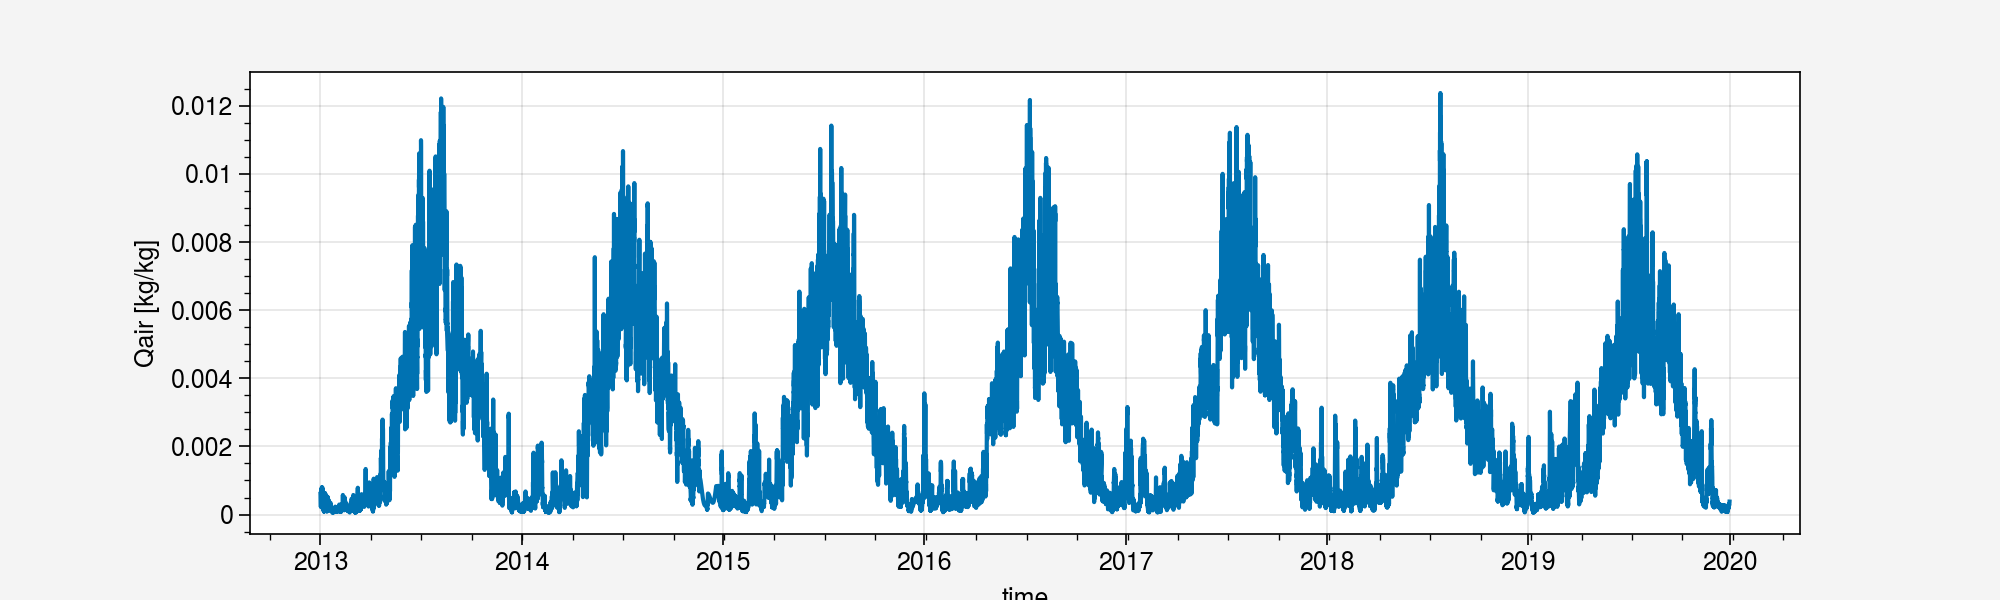

In [4]:
%matplotlib inline
for var in list(ds.keys()):
    ds[var].plot(figsize=(10,3))

In [9]:
ds.time.encoding

{'dtype': dtype('int64'),
 'zlib': False,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': True,
 'chunksizes': None,
 'source': '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/TVC/TVCSnowCLM/TVCMetData/met_insitu_tvc_2013_2019.nc',
 'original_shape': (61320,),
 'units': 'hours since 2013-01-01 00:00:00',
 'calendar': 'proleptic_gregorian'}

In [5]:
# Check if there are leap years
ds.sel(time='2016-02')

<xarray.Dataset> Size: 48kB
Dimensions:    (time: 672)
Coordinates:
  * time       (time) datetime64[ns] 5kB 2016-02-01 ... 2016-02-28T23:00:00
Data variables:
    LWdown     (time) float64 5kB ...
    TotPrecip  (time) float64 5kB ...
    Tair       (time) float64 5kB ...
    RH         (time) float64 5kB ...
    Wind       (time) float64 5kB ...
    Psurf      (time) float64 5kB ...
    SWdown     (time) float64 5kB ...
    Qair       (time) float64 5kB ...
Attributes:
    Location:     Field site located at Latitude:68.75 Longitude:226.50
    History:      File created by V. R. Dutch in Dec 2020 using TVC Station d...
    Institution:  Northumbria University, UK

### Resample to 30 minute time step for CLASSIC
Otherwise CLASSIC interpolates the forcing by itself and makes some assumptions more adapted for 6h forcing files
(e.g., for the SWdown that will lose the peaks)

In [6]:
ds_30min = ds.resample(time='30min').interpolate()
# Removes leap days (not included in original dataset)
ds_30min = ds_30min.sel(time=~((ds_30min.time.dt.month == 2) & (ds_30min.time.dt.day == 29)))
ds_30min

<xarray.Dataset> Size: 9MB
Dimensions:    (time: 122639)
Coordinates:
  * time       (time) datetime64[ns] 981kB 2013-01-01 ... 2019-12-31T23:00:00
Data variables:
    LWdown     (time) float64 981kB 238.0 237.3 236.7 ... 203.0 202.0 200.9
    TotPrecip  (time) float64 981kB 7.936e-06 7.536e-06 7.137e-06 ... 0.0 0.0
    Tair       (time) float64 981kB 254.3 254.1 253.9 ... 249.8 249.9 250.1
    RH         (time) float64 981kB 85.0 85.0 85.0 84.5 ... 79.0 79.0 79.0 79.0
    Wind       (time) float64 981kB 4.167 4.167 4.167 ... 3.333 3.333 3.333
    Psurf      (time) float64 981kB 1.006e+05 1.007e+05 ... 9.874e+04 9.874e+04
    SWdown     (time) float64 981kB 1e-10 1e-10 1e-10 ... 1e-10 1e-10 1e-10
    Qair       (time) float64 981kB 0.0006084 0.0005968 ... 0.0003765 0.0003802
Attributes:
    Location:     Field site located at Latitude:68.75 Longitude:226.50
    History:      File created by V. R. Dutch in Dec 2020 using TVC Station d...
    Institution:  Northumbria University, UK

In [7]:
# Check if there are leap years
ds_30min.sel(time='2016-02')

<xarray.Dataset> Size: 97kB
Dimensions:    (time: 1344)
Coordinates:
  * time       (time) datetime64[ns] 11kB 2016-02-01 ... 2016-02-28T23:30:00
Data variables:
    LWdown     (time) float64 11kB 254.5 252.6 250.7 247.6 ... 166.2 167.7 168.2
    TotPrecip  (time) float64 11kB 5.532e-07 7.275e-07 9.018e-07 ... 0.0 0.0 0.0
    Tair       (time) float64 11kB 258.8 257.6 256.4 256.0 ... 248.3 247.2 247.2
    RH         (time) float64 11kB 89.0 88.0 87.0 87.0 ... 73.0 75.5 78.0 77.96
    Wind       (time) float64 11kB 0.476 0.4785 0.481 0.4835 ... 2.222 2.5 2.472
    Psurf      (time) float64 11kB 1.006e+05 1.006e+05 ... 9.997e+04 9.998e+04
    SWdown     (time) float64 11kB 1e-10 1e-10 1e-10 1e-10 ... 1e-10 1e-10 1e-10
    Qair       (time) float64 11kB 0.0009616 0.000857 ... 0.0002778 0.0002782
Attributes:
    Location:     Field site located at Latitude:68.75 Longitude:226.50
    History:      File created by V. R. Dutch in Dec 2020 using TVC Station d...
    Institution:  Northumbria University, UK

### Extend beginning and the end of the forcing
Because CLASSIC only accept full years (will need to be removed for analyses)

In [8]:
time_ext = pd.date_range(
    pd.to_datetime(ds_30min.time.dt.year[0], format='%Y'), 
    str(ds_30min.time.dt.year[-1].values.item(0))+'-12-31 23:30:00',
    freq='30min'
)
time_ext

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 00:30:00',
               '2013-01-01 01:00:00', '2013-01-01 01:30:00',
               '2013-01-01 02:00:00', '2013-01-01 02:30:00',
               '2013-01-01 03:00:00', '2013-01-01 03:30:00',
               '2013-01-01 04:00:00', '2013-01-01 04:30:00',
               ...
               '2019-12-31 19:00:00', '2019-12-31 19:30:00',
               '2019-12-31 20:00:00', '2019-12-31 20:30:00',
               '2019-12-31 21:00:00', '2019-12-31 21:30:00',
               '2019-12-31 22:00:00', '2019-12-31 22:30:00',
               '2019-12-31 23:00:00', '2019-12-31 23:30:00'],
              dtype='datetime64[ns]', length=122688, freq='30T')

In [9]:
ds_30min_ext = ds_30min.reindex(time=time_ext)
ds_30min_ext

<xarray.Dataset> Size: 9MB
Dimensions:    (time: 122688)
Coordinates:
  * time       (time) datetime64[ns] 982kB 2013-01-01 ... 2019-12-31T23:30:00
Data variables:
    LWdown     (time) float64 982kB 238.0 237.3 236.7 235.7 ... 202.0 200.9 nan
    TotPrecip  (time) float64 982kB 7.936e-06 7.536e-06 7.137e-06 ... 0.0 nan
    Tair       (time) float64 982kB 254.3 254.1 253.9 253.8 ... 249.9 250.1 nan
    RH         (time) float64 982kB 85.0 85.0 85.0 84.5 ... 79.0 79.0 79.0 nan
    Wind       (time) float64 982kB 4.167 4.167 4.167 3.611 ... 3.333 3.333 nan
    Psurf      (time) float64 982kB 1.006e+05 1.007e+05 ... 9.874e+04 nan
    SWdown     (time) float64 982kB 1e-10 1e-10 1e-10 1e-10 ... 1e-10 1e-10 nan
    Qair       (time) float64 982kB 0.0006084 0.0005968 ... 0.0003802 nan
Attributes:
    Location:     Field site located at Latitude:68.75 Longitude:226.50
    History:      File created by V. R. Dutch in Dec 2020 using TVC Station d...
    Institution:  Northumbria University, UK

In [10]:
# ds_30min    : XXXXXXXXXXXXXXXXXXXXXXXXXXXX........... i_start_next_year ....... i_end_next_year
# ds_30min_ext: 1rst jan .... i_before_start

i_before_start = ds_30min_ext.sel(time=slice(None,ds_30min.time[0])).time.size - 1 
i_start_next_year = ds_30min.sel(time=slice(None, year_start)).time.size
i_end_next_year = i_start_next_year + i_before_start

# Check the dimensions are right before replacement
np.testing.assert_equal(
    ds_30min_ext['Wind'][:i_before_start].size,
    ds_30min['Wind'][i_start_next_year:i_end_next_year].size
)

for key in list(ds.keys()):
    ds_30min_ext[key][:i_before_start] = ds_30min[key][i_start_next_year:i_end_next_year].values

In [11]:
# ds_30min    : i_start_prev_year ....... i_end_prev_year.......XXXXXXXXXXXXXXXXXXXXXXXXXXXX
# ds_30min_ext: ............................................... i_after_end.......... 31 dec

i_after_end = ds_30min_ext.sel(time=slice(ds_30min.time[-1]+1, None)).time.size
i_end_prev_year = ds_30min.time.sel(time=slice(year_end, None)).time.size
i_start_prev_year = i_end_prev_year + i_after_end

# Check the dimensions are right before replacement
np.testing.assert_equal(
    ds_30min_ext['Wind'][-i_after_end:].size,
    ds_30min['Wind'][-i_start_prev_year:-i_end_prev_year].size
)

for key in list(ds.keys()):
    ds_30min_ext[key][-i_after_end:] = ds_30min[key][-i_start_prev_year:-i_end_prev_year].values

Text(0.5, 0.98, 'Trail Valley Creek, northwestern Canada')

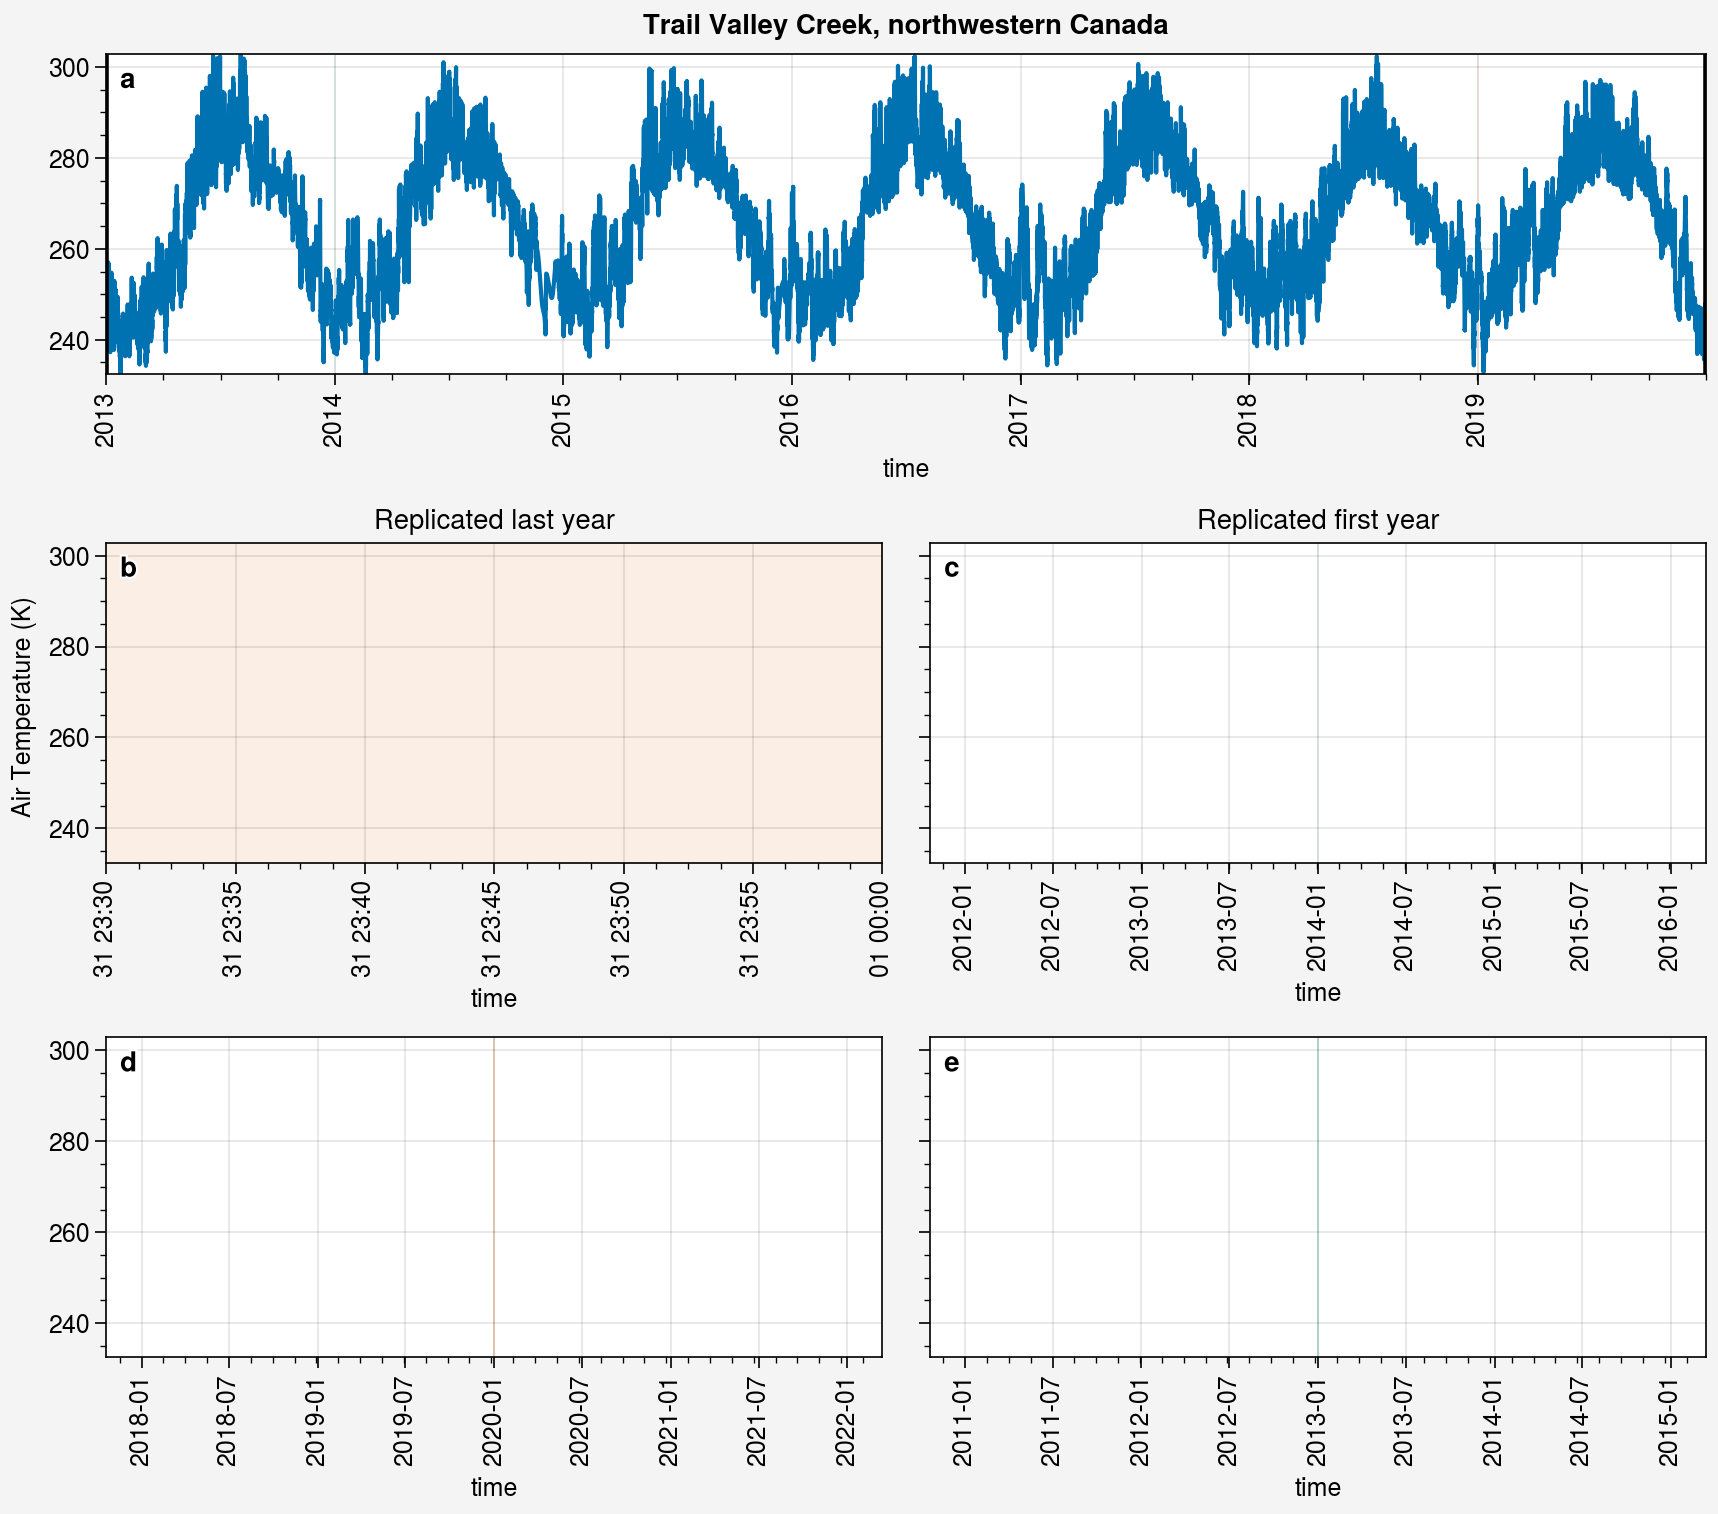

In [12]:
%matplotlib inline
fig, axs = pplt.subplots([[1, 1], [2, 3], [4, 5]], refaspect=5, refwidth=8, sharex=0)

key = 'Tair'

axs[0].plot(ds_30min_ext[key])

axs[0].fill_between(
    [ds_30min_ext[key][0].time.values, ds_30min_ext[key][i_before_start].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.3
)

axs[0].fill_between(
    [ds_30min[key][i_start_next_year].time.values, ds_30min[key][i_end_next_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.1
)

axs[0].fill_between(
    [ds_30min_ext[key][-i_after_end].time.values, ds_30min_ext[key][-1].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.3
)

axs[0].fill_between(
    [ds_30min[key][-i_start_prev_year].time.values, ds_30min[key][-i_end_prev_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.1
)

axs[0].axvline(ds_30min[key][0].time.values, lw=2, ls='-', color='k')
axs[0].axvline(ds_30min[key][-1].time.values, lw=2, ls='-', color='k')

axs[2].format(title='Replicated first year')
axs[4].plot(ds_30min_ext[key][:i_before_start])
axs[4].fill_between(
    [ds_30min_ext[key][0].time.values, ds_30min_ext[key][i_before_start].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.3
)
axs[2].plot(ds_30min[key][i_start_next_year:i_end_next_year])
axs[2].fill_between(
    [ds_30min[key][i_start_next_year].time.values, ds_30min[key][i_end_next_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.1
)

axs[1].format(title='Replicated last year')
axs[3].plot(ds_30min_ext[key][-i_after_end:])
axs[3].fill_between(
    [ds_30min_ext[key][-i_after_end].time.values, ds_30min_ext[key][-1].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.3
)
axs[1].plot(ds_30min[key][-i_start_prev_year:-i_end_prev_year])
axs[1].fill_between(
    [ds_30min[key][-i_start_prev_year].time.values, ds_30min[key][-i_end_prev_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.1
)

axs.format(abc=True, abcloc='ul')
fig.suptitle(site_longname)


In [13]:
ds_30min_ext

<xarray.Dataset> Size: 9MB
Dimensions:    (time: 122688)
Coordinates:
  * time       (time) datetime64[ns] 982kB 2013-01-01 ... 2019-12-31T23:30:00
Data variables:
    LWdown     (time) float64 982kB 238.0 237.3 236.7 ... 202.0 200.9 267.4
    TotPrecip  (time) float64 982kB 7.936e-06 7.536e-06 ... 0.0 4.633e-06
    Tair       (time) float64 982kB 254.3 254.1 253.9 ... 249.9 250.1 265.4
    RH         (time) float64 982kB 85.0 85.0 85.0 84.5 ... 79.0 79.0 79.0 90.5
    Wind       (time) float64 982kB 4.167 4.167 4.167 ... 3.333 3.333 5.833
    Psurf      (time) float64 982kB 1.006e+05 1.007e+05 ... 9.874e+04 9.786e+04
    SWdown     (time) float64 982kB 1e-10 1e-10 1e-10 ... 1e-10 1e-10 1e-10
    Qair       (time) float64 982kB 0.0006084 0.0005968 ... 0.0003802 0.001824
Attributes:
    Location:     Field site located at Latitude:68.75 Longitude:226.50
    History:      File created by V. R. Dutch in Dec 2020 using TVC Station d...
    Institution:  Northumbria University, UK

## Convert K to °C

In [14]:
ds_30min_ext['Tair'] = ds_30min_ext.Tair - 273.15
ds_30min_ext['Tair'].attrs = {'name': 'Near-Surface Air Temperature', 'unit': '°C'}
ds_30min_ext.Tair

<xarray.DataArray 'Tair' (time: 122688)> Size: 982kB
array([-18.8 , -19.  , -19.2 , ..., -23.2 , -23.1 ,  -7.75])
Coordinates:
  * time     (time) datetime64[ns] 982kB 2013-01-01 ... 2019-12-31T23:30:00
Attributes:
    name:     Near-Surface Air Temperature
    unit:     °C

In [15]:
ds_30min_ext

<xarray.Dataset> Size: 9MB
Dimensions:    (time: 122688)
Coordinates:
  * time       (time) datetime64[ns] 982kB 2013-01-01 ... 2019-12-31T23:30:00
Data variables:
    LWdown     (time) float64 982kB 238.0 237.3 236.7 ... 202.0 200.9 267.4
    TotPrecip  (time) float64 982kB 7.936e-06 7.536e-06 ... 0.0 4.633e-06
    Tair       (time) float64 982kB -18.8 -19.0 -19.2 ... -23.2 -23.1 -7.75
    RH         (time) float64 982kB 85.0 85.0 85.0 84.5 ... 79.0 79.0 79.0 90.5
    Wind       (time) float64 982kB 4.167 4.167 4.167 ... 3.333 3.333 5.833
    Psurf      (time) float64 982kB 1.006e+05 1.007e+05 ... 9.874e+04 9.786e+04
    SWdown     (time) float64 982kB 1e-10 1e-10 1e-10 ... 1e-10 1e-10 1e-10
    Qair       (time) float64 982kB 0.0006084 0.0005968 ... 0.0003802 0.001824
Attributes:
    Location:     Field site located at Latitude:68.75 Longitude:226.50
    History:      File created by V. R. Dutch in Dec 2020 using TVC Station d...
    Institution:  Northumbria University, UK

### Convert time from relative to absolute
https://sourceforge.net/p/nco/discussion/9830/thread/175b4c98e1/?limit=25

The time format `day as %Y%m%d.%f` is <mark>**required** by CLASSIC</mark>

Note: you need CDO installed to run the next cell (`!` allow to run bash command in the notebook)

In [16]:
ds_30min_ext.to_netcdf(path_tmp+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'.nc')

In [17]:
!cdo -a -f nc copy {path_tmp}/met_insitu_{site}_30min_ext_{year_start}_{year_end}.nc {path_tmp}/met_insitu_{site}_30min_ext_{year_start}_{year_end}_a.nc

cdo    copy:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    copy: Processed 981504 values from 8 variables over 122688 timesteps [10.30s 381MB]


In [55]:
!cdo del29feb {path_tmp}/met_insitu_{site}_30min_ext_{year_start}_{year_end}_a.nc {path_tmp}/met_insitu_{site}_30min_ext_{year_start}_{year_end}_a_no_leap.nc

cdo    del29feb: Processed 981120 values from 8 variables over 122688 timesteps [3.88s 533MB]


## Open the new file with absolute time

In [56]:
ds = xr.open_dataset(path_tmp+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'_a_no_leap.nc')
ds

<xarray.Dataset> Size: 9MB
Dimensions:    (time: 122640)
Coordinates:
  * time       (time) float64 981kB 2.013e+07 2.013e+07 ... 2.019e+07 2.019e+07
Data variables:
    LWdown     (time) float64 981kB ...
    TotPrecip  (time) float64 981kB ...
    Tair       (time) float64 981kB ...
    RH         (time) float64 981kB ...
    Wind       (time) float64 981kB ...
    Psurf      (time) float64 981kB ...
    SWdown     (time) float64 981kB ...
    Qair       (time) float64 981kB ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    Location:     Field site located at Latitude:68.75 Longitude:226.50
    History:      File created by V. R. Dutch in Dec 2020 using TVC Station d...
    Institution:  Northumbria University, UK
    history:      Tue Nov 19 17:10:25 2024: cdo del29feb /home/lalandmi/Dropb...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [57]:
ds.time

<xarray.DataArray 'time' (time: 122640)> Size: 981kB
array([20130101.      , 20130101.020833, 20130101.041667, ..., 20191231.9375  ,
       20191231.958333, 20191231.979167])
Coordinates:
  * time     (time) float64 981kB 2.013e+07 2.013e+07 ... 2.019e+07 2.019e+07
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       365_day
    axis:           T

### Add the lat/lon dimensions of the site (<mark>required by CLASSIC</mark>)

Note: the values of the coordinates does not seem to matter for CLASSIC (the attributes neither)

In [58]:
ds = ds.assign_coords(lon=lon)
ds = ds.expand_dims('lon')
ds['lon'] = ds.lon.assign_attrs(
    standard_name='Longitude',
    units='degrees_east',
    axis='X'
)

ds = ds.assign_coords(lat=lat)
ds = ds.expand_dims('lat')
ds['lat'] = ds.lat.assign_attrs(
    standard_name='Latitude',
    units='degrees_north',
    axis='Y'
)

# Transpose the dimension to put the time first (as required by CLASSIC)
ds = ds.transpose('time', 'lat', 'lon')

ds

<xarray.Dataset> Size: 9MB
Dimensions:    (time: 122640, lat: 1, lon: 1)
Coordinates:
  * time       (time) float64 981kB 2.013e+07 2.013e+07 ... 2.019e+07 2.019e+07
  * lon        (lon) float64 8B -133.5
  * lat        (lat) float64 8B 68.75
Data variables:
    LWdown     (time, lat, lon) float64 981kB 238.0 237.3 236.7 ... 200.9 267.4
    TotPrecip  (time, lat, lon) float64 981kB 7.936e-06 7.536e-06 ... 4.633e-06
    Tair       (time, lat, lon) float64 981kB -18.8 -19.0 -19.2 ... -23.1 -7.75
    RH         (time, lat, lon) float64 981kB 85.0 85.0 85.0 ... 79.0 79.0 90.5
    Wind       (time, lat, lon) float64 981kB 4.167 4.167 4.167 ... 3.333 5.833
    Psurf      (time, lat, lon) float64 981kB 1.006e+05 1.007e+05 ... 9.786e+04
    SWdown     (time, lat, lon) float64 981kB 1e-10 1e-10 1e-10 ... 1e-10 1e-10
    Qair       (time, lat, lon) float64 981kB 0.0006084 0.0005968 ... 0.001824
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    Location:     Field site located at Latitude:68.75 Longitude:226.50
    History:      File created by V. R. Dutch in Dec 2020 using TVC Station d...
    Institution:  Northumbria University, UK
    history:      Tue Nov 19 17:10:25 2024: cdo del29feb /home/lalandmi/Dropb...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

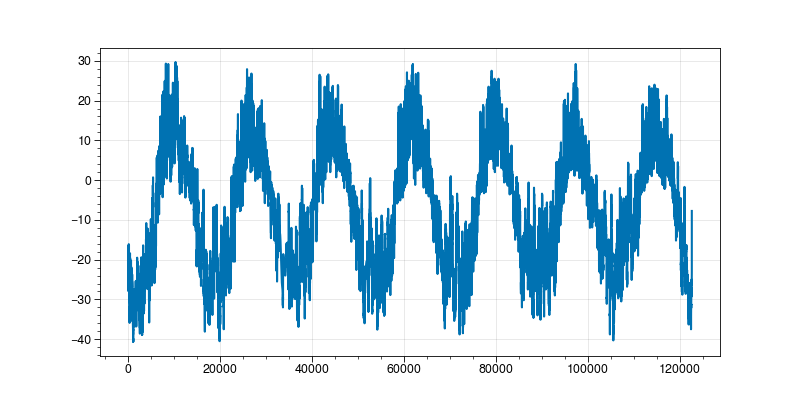

In [59]:
%matplotlib widget
plt.figure(figsize=(8,4))
plt.plot(ds.Tair.squeeze().values)

## The CDO command add back the leap days 

122639

In [60]:
ds.Tair.isnull().any()

<xarray.DataArray 'Tair' ()> Size: 1B
array(False)

In [61]:
ds.time

<xarray.DataArray 'time' (time: 122640)> Size: 981kB
array([20130101.      , 20130101.020833, 20130101.041667, ..., 20191231.9375  ,
       20191231.958333, 20191231.979167])
Coordinates:
  * time     (time) float64 981kB 2.013e+07 2.013e+07 ... 2.019e+07 2.019e+07
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       365_day
    axis:           T

In [62]:
ds.Tair.sel(time=slice('20160228.', '20160301.'))

<xarray.DataArray 'Tair' (time: 48, lat: 1, lon: 1)> Size: 384B
array([[[-25.4 ]],

       [[-24.75]],

       [[-24.1 ]],

       [[-23.9 ]],

       [[-23.7 ]],

       [[-24.1 ]],

       [[-24.5 ]],

       [[-24.7 ]],

       [[-24.9 ]],

       [[-24.75]],

...

       [[-24.2 ]],

       [[-24.35]],

       [[-24.5 ]],

       [[-24.7 ]],

       [[-24.9 ]],

       [[-24.3 ]],

       [[-23.7 ]],

       [[-24.85]],

       [[-26.  ]],

       [[-25.98]]])
Coordinates:
  * time     (time) float64 384B 2.016e+07 2.016e+07 ... 2.016e+07 2.016e+07
  * lon      (lon) float64 8B -133.5
  * lat      (lat) float64 8B 68.75
Attributes:
    name:     Near-Surface Air Temperature
    unit:     °C

### Add Rainf and Snowf (<mark>required by CLASSIC</mark>)
Already done, just check

In [31]:
# %matplotlib inline
# fig, axs = pplt.subplots(ncols=3, nrows=1, refaspect=1.5, refwidth=3)

# i_start = 2000*2
# i_end = 5000*2

# axs[0].plot(ds.Rainf.squeeze().values[i_start:i_end])
# axs[1].plot(ds.Snowf.squeeze().values[i_start:i_end])
# axs[2].plot(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end])
# axs[2].plot(ds.TotPrecip.squeeze().values[i_start:i_end])

# for ax in axs:
#     ax.format(
#         ylabel=ds.Rainf.attrs['units'], 
#         ylim=(0,max(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end]).item(0) + 0.00005)
#     )
    
# axs.format(
#     collabels=[ds.Rainf.attrs['long_name'], ds.Snowf.attrs['long_name'], 'Total precipitation']
# )


## All the procedure may introduce negative precip values due to computing precision so replace them by 0

In [63]:
ds.TotPrecip.where(ds.TotPrecip < 0).sum()

<xarray.DataArray 'TotPrecip' ()> Size: 8B
array(-2.92700502e-15)

In [64]:
ds['TotPrecip'] = ds.TotPrecip.where(ds.TotPrecip > 0, other=0)

In [65]:
np.testing.assert_equal(ds.TotPrecip.where(ds.TotPrecip < 0).sum().values, 0)

## Save forcing files

CLASSIC **requires** <mark>one file per forcing variable</mark>

Note: I save the files directly to CLASSIC folder and here to keep more flexibility in the future

In [66]:
for key in list(ds.keys()):
    ds[key].to_netcdf(path_out+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'_'+key+'.nc')
    ds[key].to_netcdf(path_out_CLASSIC+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'_'+key+'.nc')

In [67]:
!ls {path_out}

met_insitu_tvc_30min_ext_2013_2019_LWdown.nc
met_insitu_tvc_30min_ext_2013_2019_Psurf.nc
met_insitu_tvc_30min_ext_2013_2019_Qair.nc
met_insitu_tvc_30min_ext_2013_2019_RH.nc
met_insitu_tvc_30min_ext_2013_2019_SWdown.nc
met_insitu_tvc_30min_ext_2013_2019_Tair.nc
met_insitu_tvc_30min_ext_2013_2019_TotPrecip.nc
met_insitu_tvc_30min_ext_2013_2019_Wind.nc


In [68]:
!ls {path_out_CLASSIC}

met_insitu_tvc_30min_ext_2013_2019_LWdown.nc	 metVar_ap.nc
met_insitu_tvc_30min_ext_2013_2019_Psurf.nc	 metVar_lw.nc
met_insitu_tvc_30min_ext_2013_2019_Qair.nc	 metVar_pr.nc
met_insitu_tvc_30min_ext_2013_2019_RH.nc	 metVar_qa.nc
met_insitu_tvc_30min_ext_2013_2019_SWdown.nc	 metVar_sw.nc
met_insitu_tvc_30min_ext_2013_2019_Tair.nc	 metVar_ta.nc
met_insitu_tvc_30min_ext_2013_2019_TotPrecip.nc  metVar_wi.nc
met_insitu_tvc_30min_ext_2013_2019_Wind.nc


In [25]:
!ncdump -h {path_out_CLASSIC}/metVar_lw.nc

netcdf metVar_lw {
dimensions:
	lon = 1 ;
	lat = 1 ;
	time = 122688 ;
variables:
	double lon(lon) ;
		lon:standard_name = "Longitude" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	double lat(lat) ;
		lat:standard_name = "Latitude" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	double time(time) ;
		time:standard_name = "time" ;
		time:units = "day as YYYYMMDD.FFFF" ;
		time:calendar = "proleptic_gregorian" ;
	double lw(time, lat, lon) ;
		lw:_FillValue = 1.e+38 ;

// global attributes:
		:title = "Incoming long wave radiation" ;
		:units = "" ;
		:grid_type = "gaussian" ;
		:_FillValue = 1.e+38 ;
}


In [26]:
!ncdump -h {path_out_CLASSIC}/met_insitu_tvc_30min_ext_2013_2019_TotPrecip.nc

netcdf met_insitu_tvc_30min_ext_2013_2019_TotPrecip {
dimensions:
	time = 122688 ;
	lon = 1 ;
	lat = 1 ;
variables:
	double time(time) ;
		time:_FillValue = NaN ;
		time:standard_name = "time" ;
		time:units = "day as %Y%m%d.%f" ;
		time:calendar = "proleptic_gregorian" ;
		time:axis = "T" ;
	double lon(lon) ;
		lon:_FillValue = NaN ;
		lon:standard_name = "Longitude" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	double lat(lat) ;
		lat:_FillValue = NaN ;
		lat:standard_name = "Latitude" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	double TotPrecip(time, lat, lon) ;
		TotPrecip:_FillValue = NaN ;
		TotPrecip:long_name = "Precipitation" ;
		TotPrecip:units = "mm s^-1" ;
		TotPrecip:mode = "time-dependent" ;
		TotPrecip:missing_value = NaN ;
}


In [27]:
forcing_gesa = xr.open_mfdataset(path_out_CLASSIC+'/metVar_*.nc')
forcing_gesa

<xarray.Dataset> Size: 8MB
Dimensions:  (lon: 1, lat: 1, time: 122688)
Coordinates:
  * lon      (lon) float64 8B -133.5
  * lat      (lat) float64 8B 68.75
  * time     (time) float64 982kB 2.013e+07 2.013e+07 ... 2.019e+07 2.019e+07
Data variables:
    ap       (time, lat, lon) float64 982kB dask.array<chunksize=(122688, 1, 1), meta=np.ndarray>
    lw       (time, lat, lon) float64 982kB dask.array<chunksize=(122688, 1, 1), meta=np.ndarray>
    pr       (time, lat, lon) float64 982kB dask.array<chunksize=(122688, 1, 1), meta=np.ndarray>
    qa       (time, lat, lon) float64 982kB dask.array<chunksize=(122688, 1, 1), meta=np.ndarray>
    sw       (time, lat, lon) float64 982kB dask.array<chunksize=(122688, 1, 1), meta=np.ndarray>
    ta       (time, lat, lon) float64 982kB dask.array<chunksize=(122688, 1, 1), meta=np.ndarray>
    wi       (time, lat, lon) float64 982kB dask.array<chunksize=(122688, 1, 1), meta=np.ndarray>
Attributes:
    title:       Atmospheric pressure
    units:       Pa
    grid_type:   gaussian
    _FillValue:  1e+38

In [28]:
ds

<xarray.Dataset> Size: 9MB
Dimensions:    (time: 122688, lat: 1, lon: 1)
Coordinates:
  * time       (time) float64 982kB 2.013e+07 2.013e+07 ... 2.019e+07 2.019e+07
  * lon        (lon) float64 8B -133.5
  * lat        (lat) float64 8B 68.75
Data variables:
    LWdown     (time, lat, lon) float64 982kB 238.0 237.3 236.7 ... 200.9 267.4
    TotPrecip  (time, lat, lon) float64 982kB 7.936e-06 7.536e-06 ... 4.633e-06
    Tair       (time, lat, lon) float64 982kB -18.8 -19.0 -19.2 ... -23.1 -7.75
    RH         (time, lat, lon) float64 982kB 85.0 85.0 85.0 ... 79.0 79.0 90.5
    Wind       (time, lat, lon) float64 982kB 4.167 4.167 4.167 ... 3.333 5.833
    Psurf      (time, lat, lon) float64 982kB 1.006e+05 1.007e+05 ... 9.786e+04
    SWdown     (time, lat, lon) float64 982kB 1e-10 1e-10 1e-10 ... 1e-10 1e-10
    Qair       (time, lat, lon) float64 982kB 0.0006084 0.0005968 ... 0.001824
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    Location:     Field site located at Latitude:68.75 Longitude:226.50
    History:      File created by V. R. Dutch in Dec 2020 using TVC Station d...
    Institution:  Northumbria University, UK
    history:      Tue Nov 19 16:29:17 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [49]:
list(ds.keys())

['LWdown', 'TotPrecip', 'Tair', 'RH', 'Wind', 'Psurf', 'SWdown', 'Qair']

In [50]:
list(forcing_gesa.keys())

['ap', 'lw', 'pr', 'qa', 'sw', 'ta', 'wi']

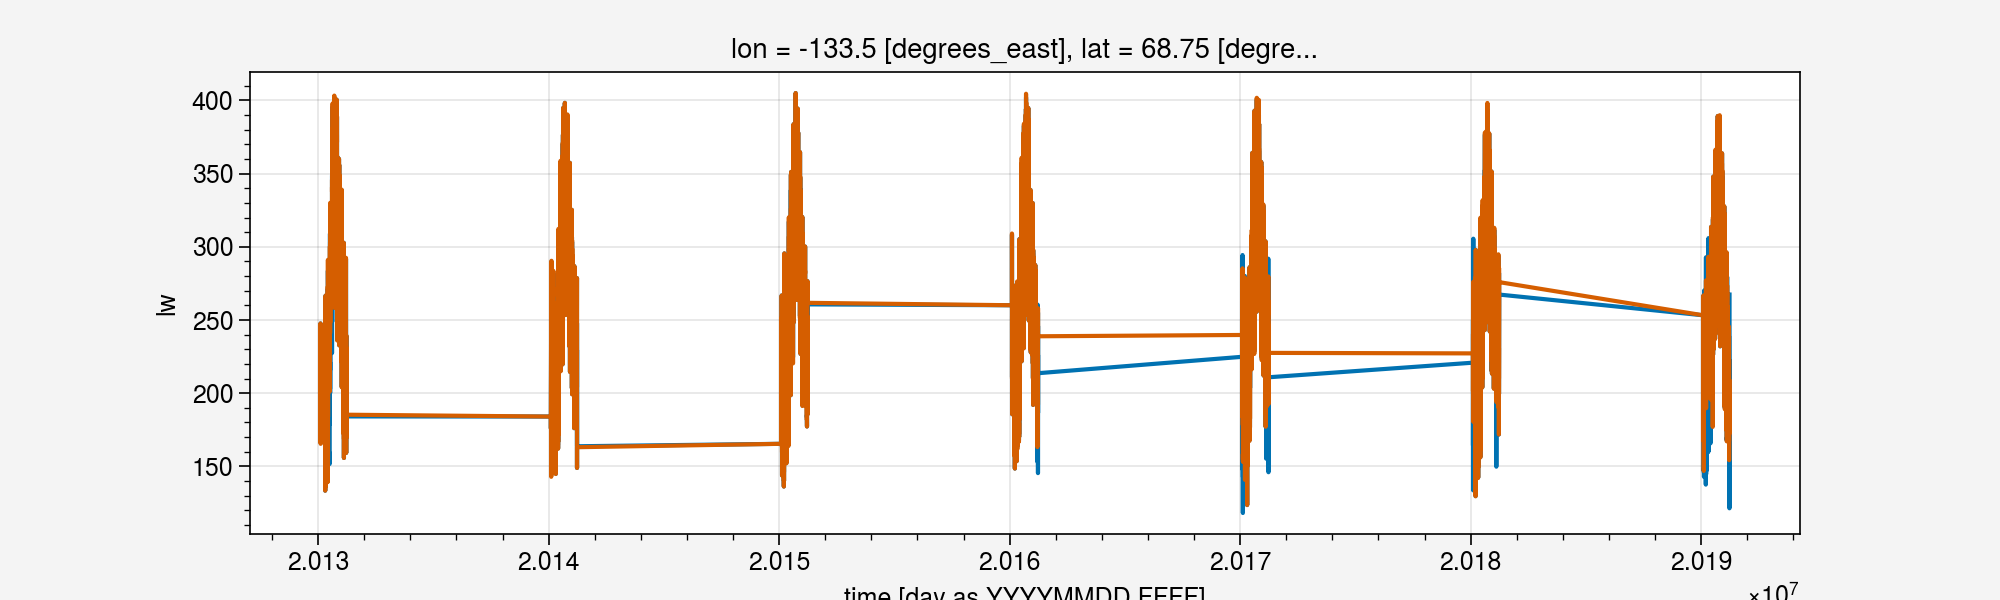

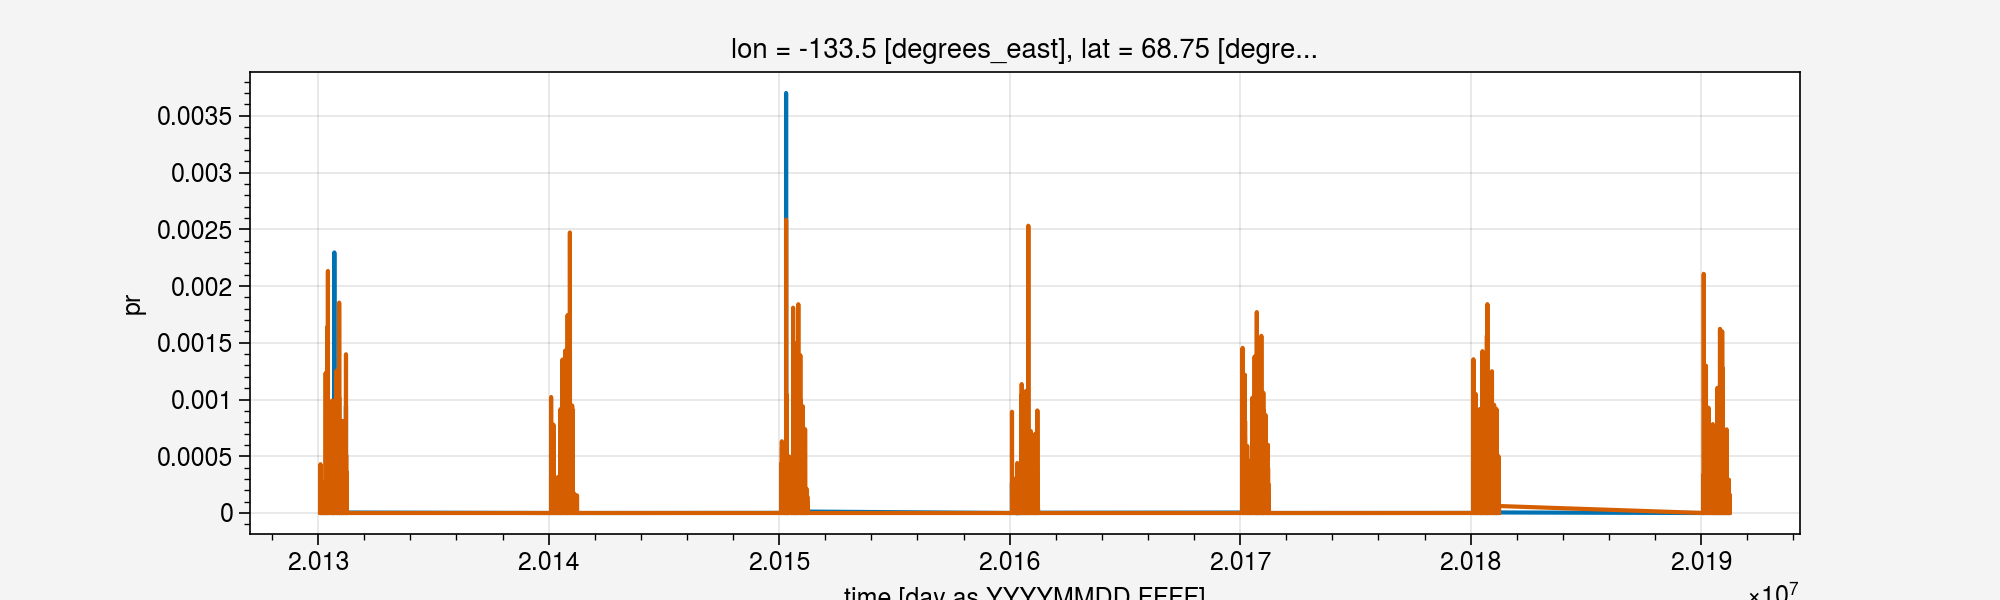

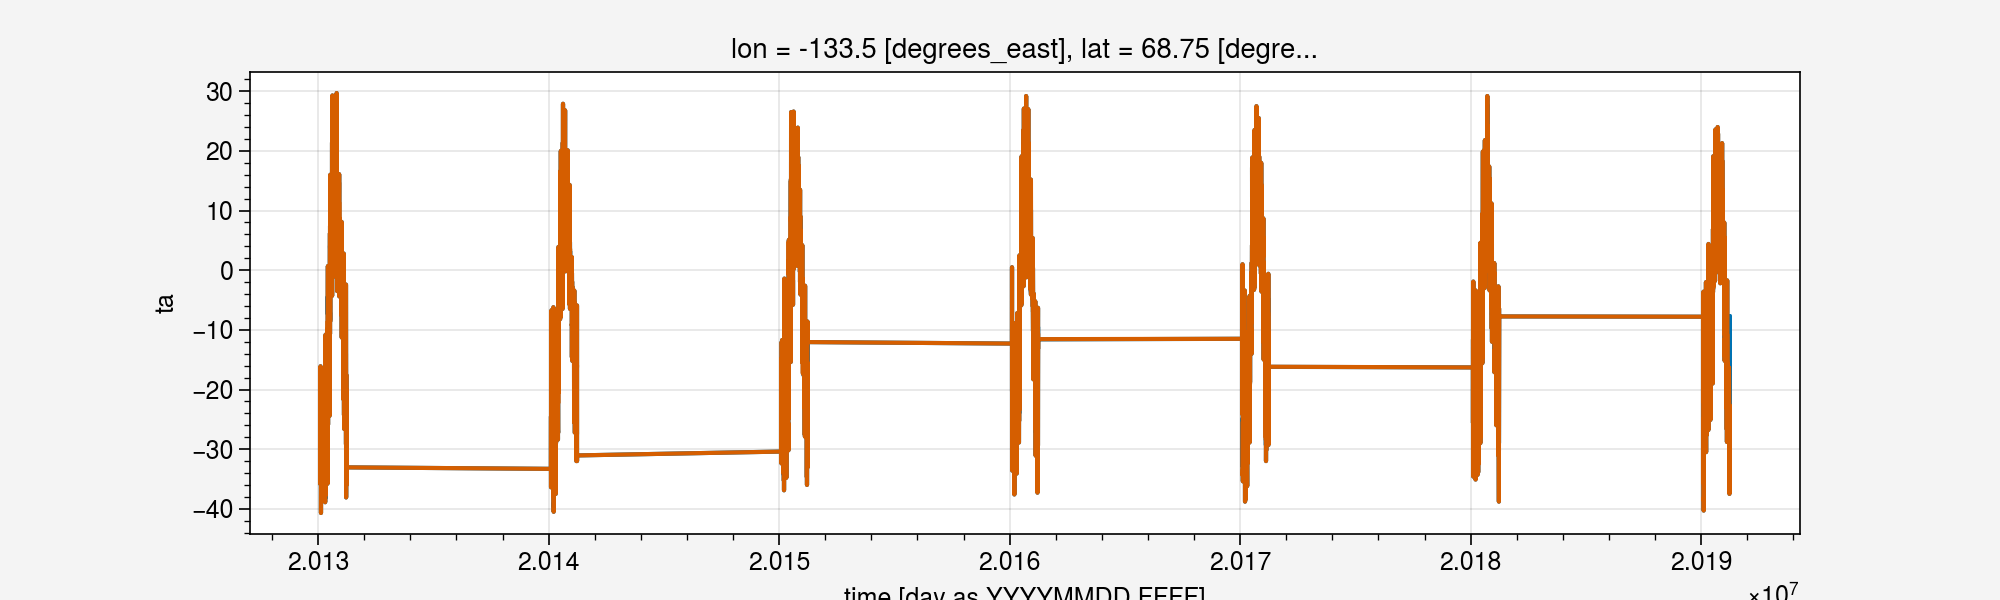

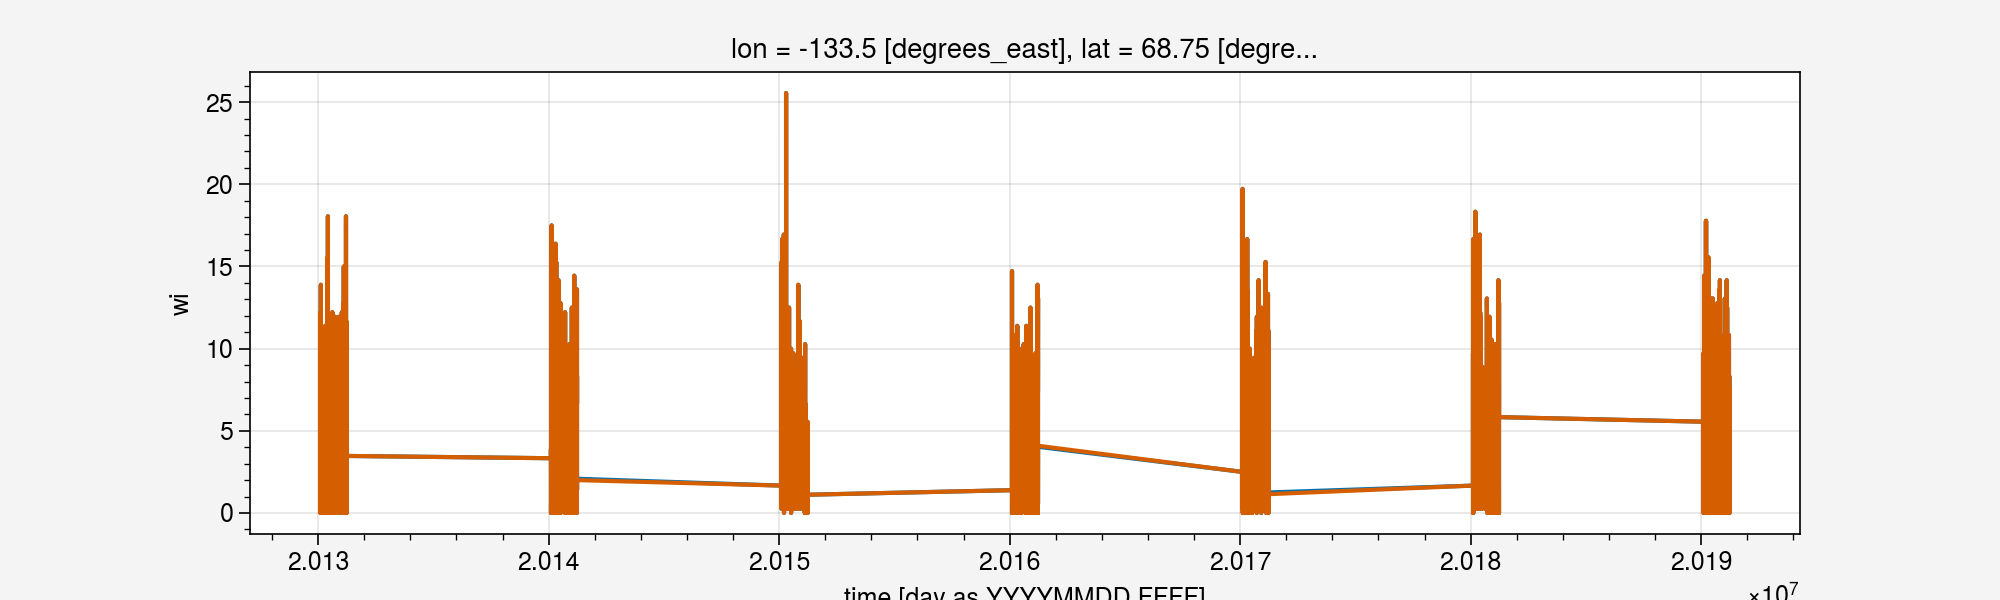

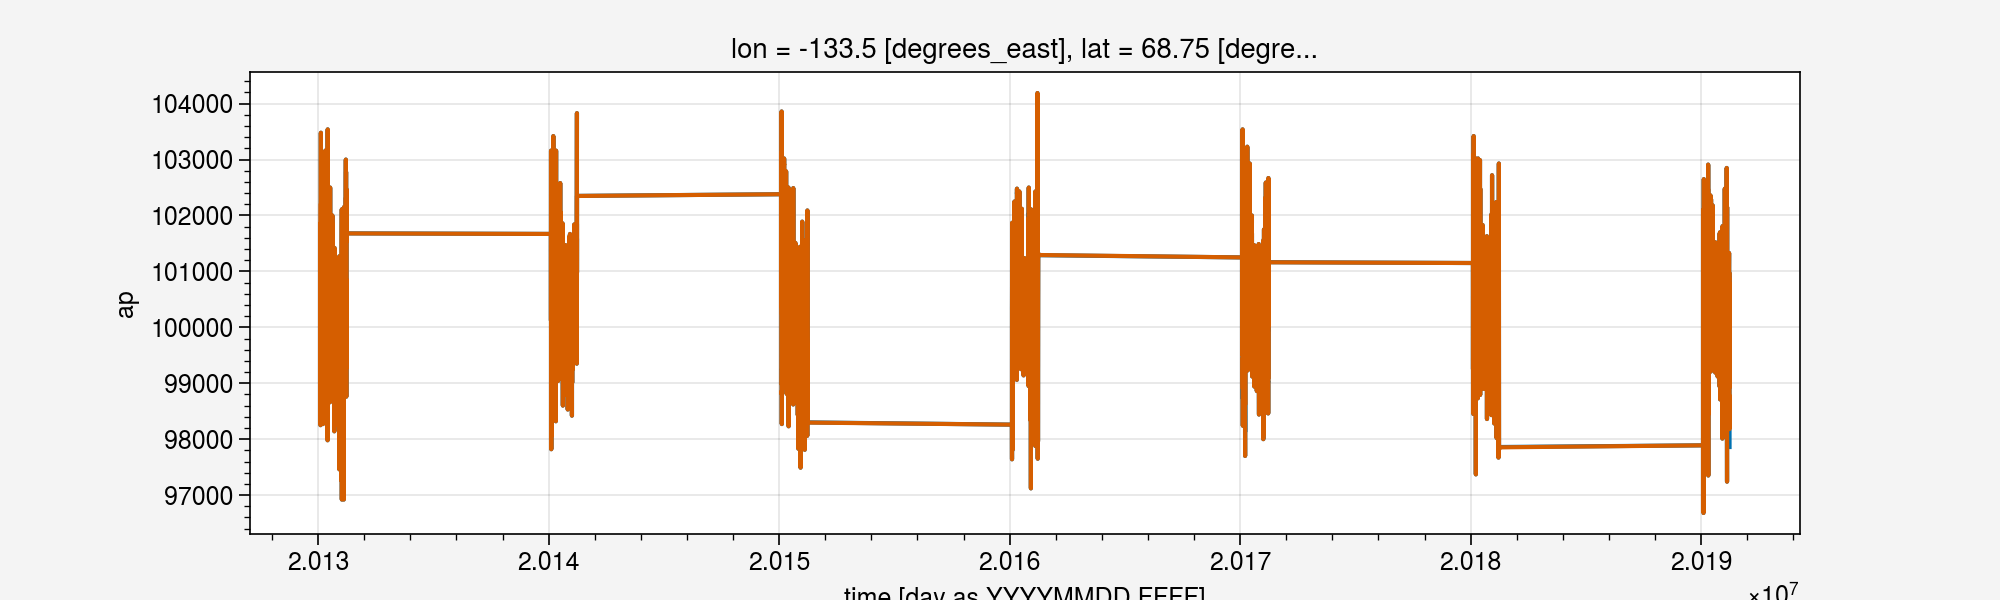

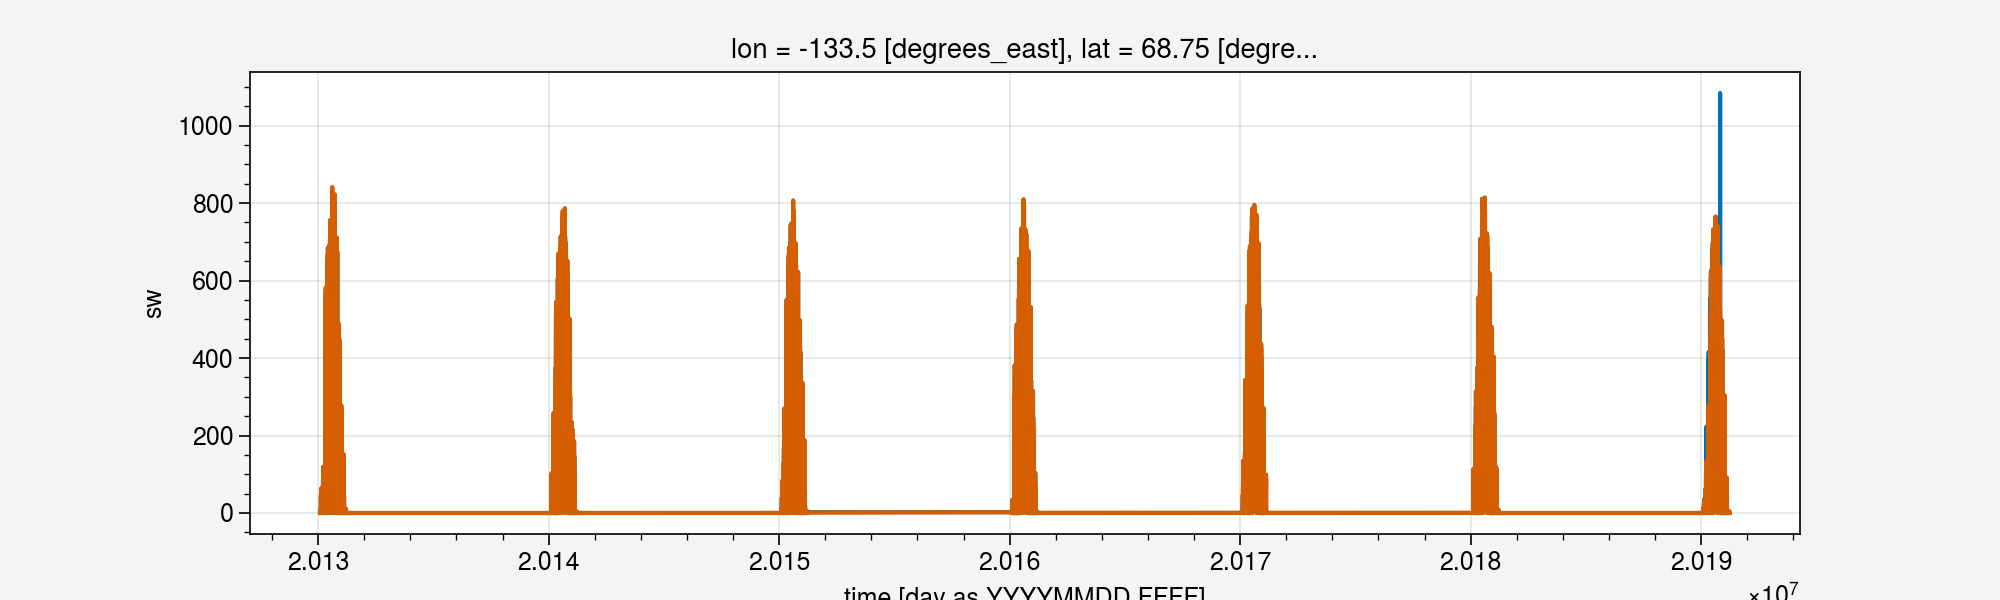

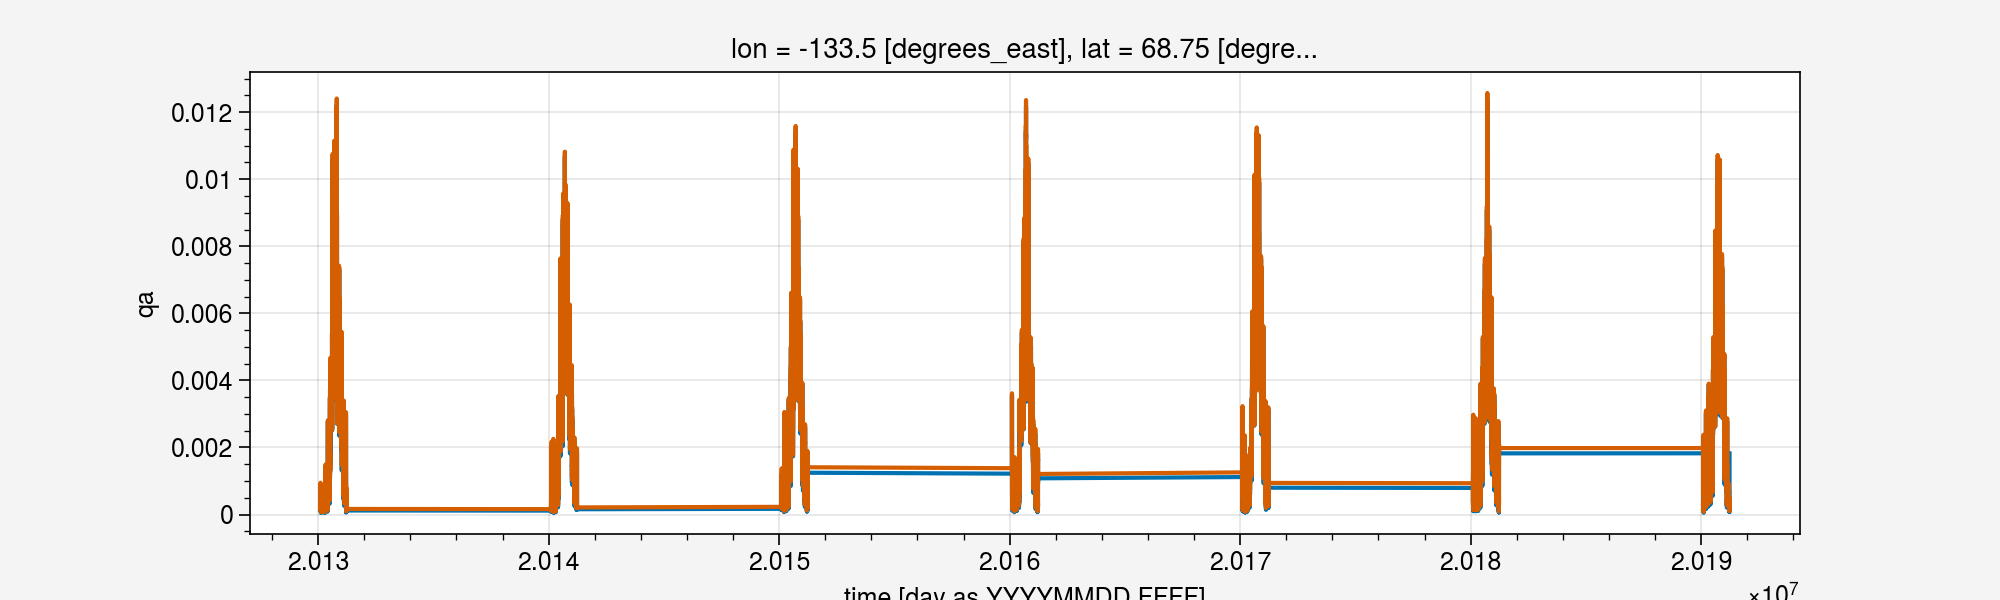

In [29]:
%matplotlib inline
for var, var2 in zip(
    ['LWdown', 'TotPrecip', 'Tair', 'Wind', 'Psurf', 'SWdown', 'Qair'], 
    ['lw', 'pr', 'ta', 'wi', 'ap', 'sw', 'qa']
):
    ds[var].plot(figsize=(10,3))
    forcing_gesa[var2].plot()